> https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

### **데이터셋 가져오기**

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/qna_for_git.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
# df.head()

### **불용어제거**
> `ex_12_version_2._stopwords.ipynb` 참조
> - okt 형태소 분석기를 이용해 inquiry를 토큰화해 단어 사전을 만들었다.
> - 토큰화된 단어들을 빈도순으로 나열했고, 그 중 `인입`, `문의`, `요청`, `확인` 이라는 명사들은 자주 등장하지만 필요한 단어가 아니라고 판단해 제거하기로 판단했다.
>> `요청` -> 사고조사 vs. 블랙박스 구분하는데 필요하다고 판단

In [3]:
# 불용어 제거 -> re.sub으로 다중 공백 제거
import re

new_memo = []
for i in range(len(df)):
    sentence = re.split("[\n | / | ) | , | _ | 재인입 | 인입 | 문의 | 요청 | 확인]", df['inquiry'][i]) # 그냥 split은 여러개 안돼서, re.split 사용
    temp = ' '.join(sentence)
    temp = re.sub(r"\s+", " ", temp).strip()
    new_memo.append(temp)

df['inquiry'] = new_memo

### **오버샘플링 적용**
> 해당 데이터는 `class imbalance`의 문제가 심함
> - 제일 많은 `내비게이션` 데이터는 1058개, 제일 적은 `충전기확인` 데이터는 4개 뿐
> - **RandomOverSampling**을 이용해 데이터를 복제해 최대 갯수인 1058개에 맞추자.

In [4]:
df['sub_type'].value_counts()

type_1     1058
type_2      675
type_4      672
type_5      642
type_3      583
type_6      389
type_7      368
type_8      348
type_13     199
type_12     190
type_10     180
type_11     158
type_15     142
type_16      90
type_18      48
type_17      46
type_14      13
type_9       11
type_20      10
type_19      10
type_21       4
Name: sub_type, dtype: int64

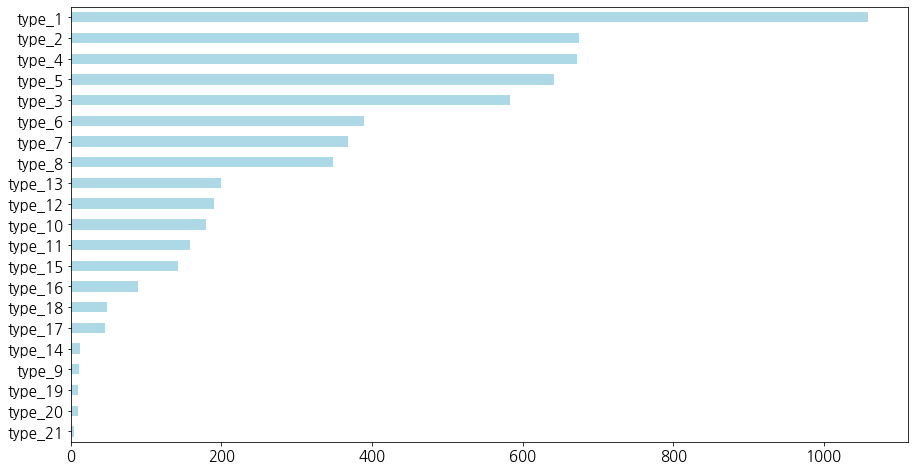

In [5]:
df['sub_type'].value_counts(ascending=True).plot.barh(figsize=(15, 8), fontsize=15, color='lightblue')

In [6]:
# 특징과 label 분리
X = df.drop('sub_type', axis=1)
y = df['sub_type']

In [7]:
X.shape, y.shape

((5836, 1), (5836,))

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# 인스턴스 생성
method = RandomOverSampler()

# 오버샘플링 적용
X, y = method.fit_resample(X, y)

X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y)

In [9]:
df = pd.concat([X, y], axis=1) # 데이터프레임(X)와 시리즈(y) 합치기

In [10]:
df['sub_type'].value_counts()

type_15    1058
type_2     1058
type_19    1058
type_21    1058
type_18    1058
type_20    1058
type_17    1058
type_14    1058
type_6     1058
type_10    1058
type_12    1058
type_5     1058
type_13    1058
type_11    1058
type_1     1058
type_16    1058
type_7     1058
type_8     1058
type_3     1058
type_4     1058
type_9     1058
Name: sub_type, dtype: int64

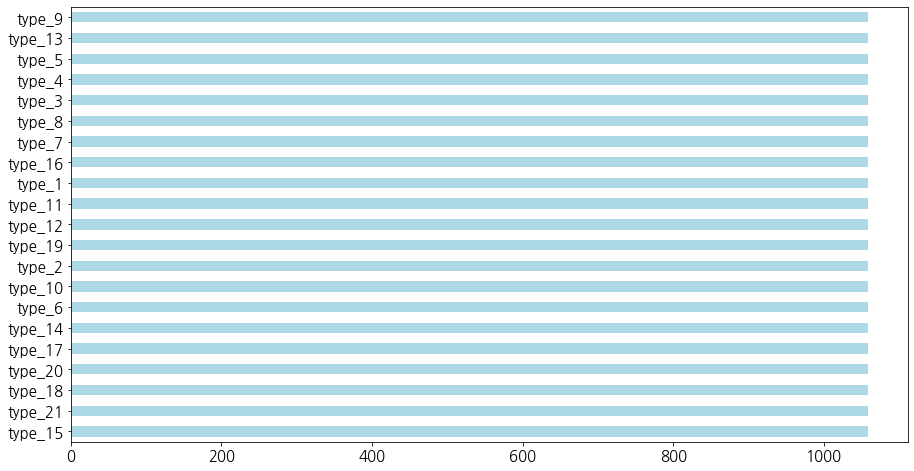

In [11]:
df['sub_type'].value_counts(ascending=True).plot.barh(figsize=(15, 8), fontsize=15, color='lightblue')

---

### **SMOTE**

In [12]:
# # X = df.drop('sub_type', axis=1)
# X = df[['inquiry']]
# y = df['sub_type']

In [13]:
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(X_train.values.ravel())
# X_train = vectorizer.transform(X_train.values.ravel())
# X_test = vectorizer.transform(X_test.values.ravel())
# X_train = X_train.toarray()
# X_test = X_test.toarray()

# x_train = pd.DataFrame(X_train)
# X_resample, y_resampled = SMOTE().fit_resample(X_train, y_train)

# X_resample = pd.DataFrame(X_resample)
# y_resampled = pd.Series(y_resampled)

In [14]:
# df =  pd.concat([X_resample, y_resampled], axis=1)
# df

In [15]:
X.shape, y.shape

((22218, 1), (22218,))

### **train, test set 분리**

In [16]:
from sklearn.model_selection import train_test_split

# train_test_split
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=930,
                                     stratify=df['sub_type'].values)

In [17]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
df_train['sub_type'].nunique(), df_test['sub_type'].nunique()

(21, 21)

### **sub_type을 categorical data로**

In [22]:
# 정수 인코딩
sub_type_mapping = {
    'type_1': 0,
    'type_2': 1,
    'type_3': 2,
    'type_4': 3,
    'type_5': 4,
    'type_6': 5,
    'type_7': 6,
    'type_8': 7,
    'type_9': 8,
    'type_10': 9,
    'type_11': 10,
    'type_12': 11,
    'type_13': 12,
    'type_14': 13,
    'type_15': 14,
    'type_16': 15,
    'type_17': 16,
    'type_18': 17,
    'type_19': 18,
    'type_20': 19,
    'type_21': 20
}

func = lambda x: sub_type_mapping.get(x, x)

In [23]:
df_train['sub_type'] = df_train['sub_type'].map(func)
df_test['sub_type'] = df_test['sub_type'].map(func)

In [24]:
# target data를 categorical 형태로 변환
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['sub_type'])
y_test = to_categorical(df_test['sub_type'])

### **트랜스포머**

In [25]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.0 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 596 kB 77.3 MB/s 
     |████████████████████████████████| 6.6 MB 50.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


> - `AutoTokenizer`: 다양한 타입의 tokenizer 포함
> - `TFBertModel`: 텐서플로우에서 사용하는 pre-trained된 Bert
>> 한국어를 사용하기 위해 100개 이상의 언어로 사전학습된 **`bert-base-multilingual-cased`** BERT를 이용하자.

In [26]:
# import transformers
# from transformers import AutoTokenizer, TFBertModel

# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# bert = TFBertModel.from_pretrained('bert-base-cased')

In [27]:
import transformers
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
bert = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
tokenizer.tokenize('I have a new GPU!')

['I', 'have', 'a', 'new', 'GPU', '!']

In [29]:
tokenizer.tokenize('내비게이션이 잘 안 됩니다!')

['내', '##비', '##게', '##이션', '##이', '잘', '안', '[UNK]', '!']

### **Input Data Modeling**
> Input 텍스트 데이터를 tokenizer를 사용해 Bert의 input 형식으로 맞추자.

In [30]:
x_train = tokenizer(
    text = df_train['inquiry'].tolist(),
    add_special_tokens=True, # CLS, SEP
    max_length=70, # 각 sentence의 최대 길이. 이보다 크면 잘리고 작으면 padding될 것.
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False, # 여기서 필요하지 x
    return_attention_mask=True, # input으로 attention_mask를 포함시키고 싶음
    verbose=True
)

x_test = tokenizer(
    text=df_test['inquiry'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose = True
)

> data modeling이후 tokenizer은 `input_ids`와 `attention_mask`를 key로 갖는 dictionary를 반환

> tokenizer에 tex를 넣고 item을 출력해보면
> - input_ids: 우리의 input 토큰에 대해 vocab dic의 key 값을 출력
> - attention_mask: special token인지 아닌지 출력해줌
> - token_type_ids: 0번째 문장인지, 1번째 문장인지에 대해 출력

In [31]:
# print(x_train[0].tokens)

In [32]:
print(x_train[0].ids)

[101, 10003, 42337, 9378, 118855, 118963, 12605, 11287, 9141, 65164, 76820, 11664, 9952, 71013, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [33]:
print(x_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
x_train

{'input_ids': <tf.Tensor: shape=(17774, 70), dtype=int32, numpy=
array([[  101, 10003, 42337, ...,     0,     0,     0],
       [  101,  9678, 15891, ...,     0,     0,     0],
       [  101,  9665, 12310, ...,     0,     0,     0],
       ...,
       [  101,  9597, 14646, ...,     0,     0,     0],
       [  101,  9730, 44321, ...,     0,     0,     0],
       [  101,  9561, 18623, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(17774, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [35]:
input_ids = x_train['input_ids'] # input 토큰에 대한 key
attention_mask = x_train['attention_mask'] # special token인지 아닌지

### **Model Building**
> functional API 사용

In [36]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [37]:
max_len = 70

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids, attention_mask=input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
y = Dense(21, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

### **모델 Compilation**
> parameter 정의하고, model compile하기

In [38]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model, taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy') # 모든 class들에 대해 평균 accuarcy

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss, 
    metrics=metric)

### **모델 Training**
> x_test는 전처리 이후 `input_ids`, `attention_mask`를 포함해 사전 형태가 되었다.
> - 이 두 값을 training을 위해 사용하자.

In [39]:
train_history = model.fit(
    x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']},
    y = y_train,
    validation_data = (
    {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, y_test
    ),
  epochs=10,
  batch_size=36
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


494/494 [==============================] - 228s 402ms/step - loss: 1.0031 - balanced_accuracy: 0.7388 - val_loss: 0.5141 - val_balanced_accuracy: 0.8639
Epoch 2/10
494/494 [==============================] - 194s 392ms/step - loss: 0.4416 - balanced_accuracy: 0.8855 - val_loss: 0.3669 - val_balanced_accuracy: 0.9055
Epoch 3/10
494/494 [==============================] - 194s 392ms/step - loss: 0.3382 - balanced_accuracy: 0.9116 - val_loss: 0.3329 - val_balanced_accuracy: 0.9183
Epoch 4/10
494/494 [==============================] - 194s 392ms/step - loss: 0.2886 - balanced_accuracy: 0.9263 - val_loss: 0.2988 - val_balanced_accuracy: 0.9257
Epoch 5/10
494/494 [==============================] - 194s 393ms/step - loss: 0.2534 - balanced_accuracy: 0.9346 - val_loss: 0.2835 - val_balanced_accuracy: 0.9302
Epoch 6/10
494/494 [==============================] - 194s 392ms/step - loss: 0.2351 - balanced_accuracy: 0.9381 - val_loss: 0.2695 - val_balanced_accuracy: 0.9311
Epoch 7/10
494/494 [=======

### **모델 평가**

In [40]:
predicted_raw = model.predict({'input_ids': x_test['input_ids'],
                               'attention_mask': x_test['attention_mask']})
predicted_raw[0]

array([2.3231773e-04, 4.5525871e-06, 1.3681886e-05, 5.0379481e-06,
       7.5614487e-08, 5.3966600e-05, 3.7494145e-05, 6.5401859e-05,
       4.0633848e-05, 6.5432614e-05, 6.9297431e-04, 8.9172318e-08,
       1.8534864e-06, 1.1099766e-04, 8.7587074e-07, 4.8102424e-06,
       6.4587061e-06, 4.0399769e-05, 5.9117392e-05, 9.9855655e-01,
       7.1016648e-06], dtype=float32)

In [41]:
# maximum 확률값을 가지는 value의 index
y_predicted = np.argmax(predicted_raw, axis=1)
y_true = df_test['sub_type']

### **성능 지표**

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       212
           1       0.90      0.91      0.91       212
           2       0.85      0.78      0.82       212
           3       0.88      0.92      0.90       211
           4       0.82      0.84      0.83       211
           5       0.94      0.85      0.89       211
           6       0.89      0.91      0.90       212
           7       0.92      0.91      0.91       211
           8       0.99      1.00      1.00       212
           9       0.92      0.92      0.92       212
          10       0.96      0.97      0.96       212
          11       0.96      0.95      0.95       211
          12       0.97      0.99      0.98       211
          13       1.00      1.00      1.00       211
          14       0.97      1.00      0.98       212
          15       0.97      0.99      0.98       211
          16       0.96      1.00      0.98       212
          17       0.99    

### **Prediction Pipeline**

In [43]:
sub_type_mapping_new = dict(zip(sub_type_mapping.values(), sub_type_mapping.keys()))
sub_type_mapping_new

{0: 'type_1',
 1: 'type_2',
 2: 'type_3',
 3: 'type_4',
 4: 'type_5',
 5: 'type_6',
 6: 'type_7',
 7: 'type_8',
 8: 'type_9',
 9: 'type_10',
 10: 'type_11',
 11: 'type_12',
 12: 'type_13',
 13: 'type_14',
 14: 'type_15',
 15: 'type_16',
 16: 'type_17',
 17: 'type_18',
 18: 'type_19',
 19: 'type_20',
 20: 'type_21'}

In [44]:
# sub_type_mapping_new = {v: k in k, v in sub_type_mapping.items()}

> 데이터를 training data와 같은 형식으로 변환하고 `model.predict()`를 불러줘야 한다.

In [45]:
while(1):
    texts = input(str('input the text: '))
    if texts == '.':
        break

    x_val = tokenizer(
        text=texts,
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding='max_length', 
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose = True)

    validation = model.predict({'input_ids': x_val['input_ids'],
                                'attention_mask': x_val['attention_mask']})*100

    score = (-validation).argsort()
    for i in score[0]:
        print(sub_type_mapping_new.get(i), '  ', validation[0][i])

# for key, value in zip(sub_type_mapping.get(score[0]), validation[0]):
#     print(key, value)

input the text: 내비게이션이 잘 안됩니다.
type_1    99.18331
type_17    0.25126734
type_7    0.18267348
type_12    0.12175131
type_3    0.108943544
type_18    0.048478216
type_9    0.03368791
type_15    0.018439235
type_6    0.014056503
type_2    0.006965464
type_20    0.0061952886
type_11    0.0057048425
type_16    0.0052538184
type_14    0.004081619
type_13    0.003854241
type_19    0.0014637226
type_8    0.0014486536
type_4    0.0012466209
type_5    0.00071626616
type_21    0.000298111
type_10    0.00015527378
input the text: 타이어가 펑크났어요
type_2    99.37326
type_13    0.27413943
type_6    0.06643165
type_3    0.06293204
type_19    0.057283062
type_7    0.048876327
type_11    0.041744616
type_16    0.021679277
type_8    0.014157691
type_5    0.008660929
type_20    0.008235473
type_18    0.008191717
type_10    0.0058579585
type_14    0.0038849642
type_1    0.0015118943
type_9    0.0010114528
type_21    0.00054435874
type_4    0.0005335296
type_17    0.0005030027
type_15    0.00035422674
type_12   